# Target Selection

### Goals:
- Confirm if the ATA is able to observe Luyten's Star (GJ 273)

### Steps:
1. Define observer (ATA)
2. Define constraints
3. Check if GJ 273 can be seen w/ ATA given constraints

### Defining the Observer (ATA)

Ref: https://astroplan.readthedocs.io/en/latest/getting_started.html

In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import EarthLocation
from pytz import timezone
from astroplan import Observer

In [44]:
# Define ATA location parameters

longitude = (-(121+28.0/60+24.0/3600))*u.deg
latitude = (40+49.0/60+3.0/3600)*u.deg
elevation = 1008*u.m

location = EarthLocation(longitude, latitude, elevation) # confirm if coords are geocentric or geodesic!

In [45]:
# Define observer

ATA = Observer(name = 'Allen Telescope Array',
              location = location, 
              timezone = timezone('US/Pacific'),
              description = "Allen Telescope Array @ Hat Creek Radio Observatory, CA")

### Defining Constraints

Ref: https://astroplan.readthedocs.io/en/latest/tutorials/constraints.html

In [4]:
from astroplan import FixedTarget
from astropy.time import Time

In [158]:
# Define observation time ranges

time_range = Time(["2021-07-20 00:00", "2021-08-14 00:00"])
time_range

<Time object: scale='utc' format='iso' value=['2021-07-20 00:00:00.000' '2021-08-14 00:00:00.000']>

In [187]:
# Read in table of targets

from astropy.table import Table

target_table = Table.read('ata-targets.txt', format='ascii') # ata-catalogue.txt taken from https://github.com/SETIatHCRO/gr-ata/blob/master/docs/ata-catalog.txt

In [188]:
# Create FixedTarget objects for each target in the table

from astropy.coordinates import SkyCoord

targets = [FixedTarget(coord=SkyCoord(ra=ra*u.deg, dec=dec*u.deg), 
                       name=name) for name, ra, dec in target_table]

In [189]:
# Set up constraints

from astroplan import (AltitudeConstraint, AtNightConstraint, MoonSeparationConstraint, MoonIlluminationConstraint, SunSeparationConstraint) # Q: Do I need to consider airmass constraint?

constraints = [AltitudeConstraint(20*u.deg, 89*u.deg), 
               # AtNightConstraint.twilight_astronomical(), --> not needed for radio astronomy??
               MoonSeparationConstraint(min=15*u.deg), 
               SunSeparationConstraint(min=15*u.deg)] # How to determine minimum moon separation?

In [190]:
# Visualising constraints

### Determine Observability of Targets

In [191]:
from astroplan import is_observable, is_always_observable, months_observable

In [192]:
# Are the targets ever observable in the time range?
ever_observable = is_observable(constraints, ATA, targets, time_range=time_range)

In [193]:
# Are the targets always observable in the time range?
always_observable = is_always_observable(constraints, ATA, targets, time_range=time_range)

In [194]:
# Months observable
# months_observable(constraints, ATA, targets)

In [195]:
import pandas as pd

In [200]:
observable = Table()
observable['Target'] = [target.name for target in targets]
observable['Ever Observable'] = ever_observable
observable['Always Observable'] = always_observable
observable['Rise Time'] = ATA.target_rise_time(time, targets, which="next")
observable['Set Time'] = ATA.target_set_time(time, targets, which="next")

In [203]:
df = observable.to_pandas()
df_obs = df.drop(df[df['Ever Observable'] == False].index)
df_obs.sort_values(by = 'Rise Time', ascending = True)

,Target,Ever Observable,Always Observable,Rise Time,Set Time
3,k2-72,True,False,2021-07-20 05:05:58.340696990,2021-07-20 15:57:40.002838075
16,trappist-1,True,False,2021-07-20 05:37:40.214227438,2021-07-20 17:01:38.860591650
10,luyten-alt,True,False,2021-07-20 06:25:15.292525291,2021-07-20 19:00:15.698915720
17,trappist-1-alt,True,False,2021-07-20 08:03:11.759584844,2021-07-20 19:27:08.031148016
14,teegarden,True,False,2021-07-20 08:05:39.399339259,2021-07-20 22:05:36.590033770
13,tau_Cet,True,False,2021-07-20 08:54:15.678632855,2021-07-20 18:59:11.796305180
9,luyten,True,False,2021-07-20 13:22:15.754720867,2021-07-20 02:00:05.049271882
12,ross128,True,False,2021-07-20 17:57:24.685453177,2021-07-20 06:04:06.989205480
4,keppler-62,True,False,2021-07-20 20:59:37.546168864,2021-07-20 17:08:57.702105939
7,keppler-1229,True,False,2021-07-20 21:28:28.042998612,2021-07-20 18:34:00.850205719


In [174]:
# from astroplan import observability_table

# table = observability_table(constraints, ATA, targets, time_range=time_range)

In [172]:
# df = table.to_pandas()
# df.sort_values(by = 'fraction of time observable', ascending = False)

In [175]:
# df_observable = df.drop(df[df['ever observable'] == False].index)
# df_observable.sort_values(by = 'fraction of time observable', ascending = False)

In [19]:
obs_target_table = Table.read('ata-targets-observable.txt', format='ascii')

obs_targets = [FixedTarget(coord=SkyCoord(ra=ra*u.deg, dec=dec*u.deg), 
                       name=name) for name, ra, dec in obs_target_table]

### Determine Rise-Set Times
- Keeping in mind elevation constraint of 20deg

In [120]:
from astropy.coordinates import AltAz

In [147]:
t_start = Time("2021-07-20 00:00")
t_end = Time("2021-08-14 00:00")
t_range = t_start + (t_end - t_start)*np.linspace(0, 1, 1250) # 25 days total

t_i = Time("2021-07-20 00:00")
t_f = Time("2021-07-20 23:00")
t_r = t_i + (t_f - t_i)*np.linspace(0, 1, 24)

In [149]:
# Find times where the altitude crosses 20 deg (elevation limit of ATA)

altaz = AltAz(obstime=t_range, location=location)

In [150]:
for name, ra, dec in obs_target_table:
    radec = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
#    print(radec, name)

In [151]:
obs_targets_altaz = radec.transform_to(altaz)
alts = obs_targets_altaz.alt
alt_lim = alts.deg - 20

In [152]:
for alt in alts:
    altzc = t_r[np.where(alt_lim[:-1] * alt_lim[1:] < 0)]
    try:
        altz1t = min(altzc)
        altz2t = max(altzc)
        altz1 = str(TimeDelta(altz1t, format='sec').to_datetime())
        altz2 = str(TimeDelta(altz2t, format='sec').to_datetime())
        print("Target crosses 30 degreesat %s and %s" % (altz1, altz2))
    except:
        altz1 = 0 * u.h
        altz2 = 24 * u.h
        print("Target never crosses 30 degrees")

IndexError: index 52 is out of bounds for axis 0 with size 24

### Plot Sky Chart of Targets

In [20]:
import matplotlib.pyplot as plt
from astroplan.plots import plot_sky
from astropy.coordinates import get_moon, get_sun

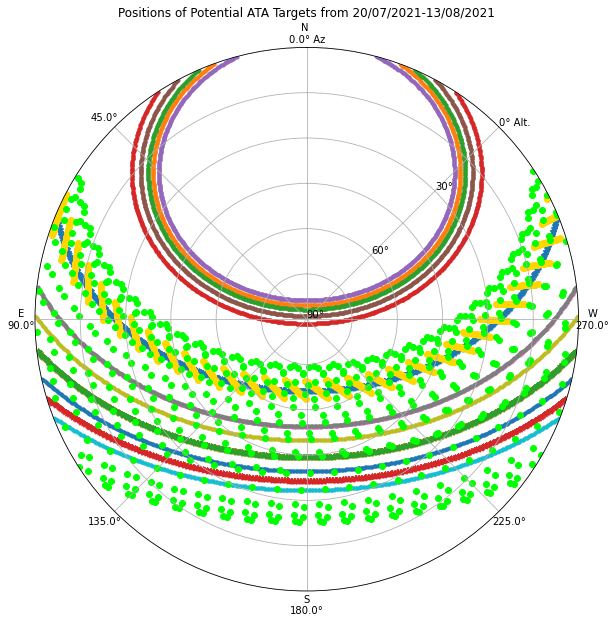

In [119]:
# Sky chart for 3-week period from 20/07/2021-13/08/2021 

i = 0
sun = get_sun(t_range)
moon = get_moon(t_range, location=location)

plt.figure(figsize=(15,10))
for obs_target in obs_targets:
    i = i + 1
    if i < 11:
        plot_sky(obs_target, ATA, t_range, style_kwargs={'marker': '.'}, warn_below_horizon = True)
        # print(i, '< 11')
    else:
        plot_sky(obs_target, ATA, t_range, style_kwargs={'marker': '*'}, warn_below_horizon = True)
        # print(i, '>=11')
plot_sky(sun, ATA, t_range, style_kwargs={'color': 'gold', 'label': 'Sun'}, warn_below_horizon = True)
plot_sky(moon, ATA, t_range, style_kwargs={'color': 'lime', 'label': 'Moon'}, warn_below_horizon = True)
plt.title('Positions of Potential ATA Targets from 20/07/2021-13/08/2021')
#plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0.)
plt.show()

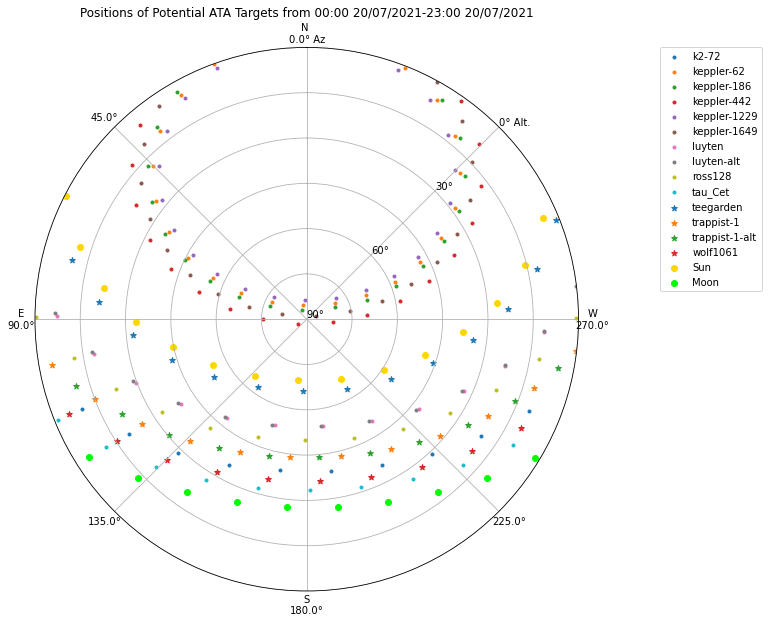

In [116]:
# Sky chart for 23-hr period (to view relative start and end positions)

i = 0

moonday = get_moon(t_r, location=location)
sunday = get_sun(t_r)

plt.figure(figsize=(15,10))
for obs_target in obs_targets:
    i = i + 1
    if i < 11:
        plot_sky(obs_target, ATA, t_r, style_kwargs={'marker': '.'})#, warn_below_horizon = True)
        # print(i, '< 11')
    else:
        plot_sky(obs_target, ATA, t_r, style_kwargs={'marker': '*'})#, warn_below_horizon = True)
        # print(i, '>=11')
plot_sky(sunday, ATA, t_r, style_kwargs={'color': 'gold', 'label': 'Sun'})#, warn_below_horizon = True)
plot_sky(moonday, ATA, t_r, style_kwargs={'color': 'lime', 'label': 'Moon'})#, warn_below_horizon = True)
plt.title('Positions of Potential ATA Targets from 00:00 20/07/2021-23:00 20/07/2021')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0.)
plt.show()

### To Do
- Visualisation of constraints
- Plot seems to be wrong? Fix plot